Convolution sequence to sequence model for German to English Translation

We have previously seen RNN models for Sequence to sequence models. They suffer from vanishing/exploding gradient problems. Training and computation is also slow.

This paper introduces the use of CNN for Machine Translation. This improves computation time as processing is done in parallel as against sequential processing in RNN. This has also proved to be more effective than RNN models.


This notebook has the Implementation of [Convolutional Sequence to Sequence Learning](https://arxiv.org/pdf/1705.03122.pdf) paper
# Convolutional Seq2Seq

![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq0.png)



In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import random
import time
import math

In [ ]:
SEED = 1234

random.seed(SEED)
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!python -m spacy download en
!python -m spacy download de

In [ ]:
spacy_de = spacy.load('de')
spacy_en = spacy.load('en')

In [ ]:
def tokenize_de(text):
  """Tokenize German text from a string into a list of tokens"""
  return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
  """Tokenize English text from a string into a list of tokens"""
  return [tok.text for tok in spacy_en.tokenizer(text)]

In [ ]:
# Create tokenised list for both German and English
SRC = Field(tokenize = tokenize_de,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)


TRG = Field(tokenize = tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first = True)

In [ ]:
print(vars((SRC)))

{'sequential': True, 'use_vocab': True, 'init_token': '<sos>', 'eos_token': '<eos>', 'unk_token': '<unk>', 'fix_length': None, 'dtype': torch.int64, 'preprocessing': None, 'postprocessing': None, 'lower': True, 'tokenize': <function tokenize_de at 0x7f52f324e8c8>, 'include_lengths': False, 'batch_first': True, 'pad_token': '<pad>', 'pad_first': False, 'truncate_first': False, 'stop_words': None, 'is_target': False}


In [ ]:
# Create train, validation and test set partitions
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de','.en'),
                fields = (SRC,TRG))


downloading training.tar.gz


training.tar.gz: 100%|██████████| 1.21M/1.21M [00:02<00:00, 536kB/s]


downloading validation.tar.gz


validation.tar.gz: 100%|██████████| 46.3k/46.3k [00:00<00:00, 170kB/s]


downloading mmt_task1_test2016.tar.gz


mmt_task1_test2016.tar.gz: 100%|██████████| 66.2k/66.2k [00:00<00:00, 162kB/s]


In [ ]:
for i in train_data:
  print(i.src)
  print(i.trg)
  break

['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche', '.']
['two', 'young', ',', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.']


In [ ]:
SRC.build_vocab(train_data, min_freq = 2)

TRG.build_vocab(train_data, min_freq = 2)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 128

# numericalize the tokens and create iterators
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

In [ ]:
for i in train_iterator:
  print(i.src)
  print(i.trg)
  break

tensor([[   2,    8,   16,  ...,    1,    1,    1],
        [   2,   54, 1552,  ...,    1,    1,    1],
        [   2,    5,  717,  ...,    1,    1,    1],
        ...,
        [   2,    8,   36,  ...,    1,    1,    1],
        [   2,    5,   13,  ...,    1,    1,    1],
        [   2,    5,   13,  ...,    1,    1,    1]], device='cuda:0')
tensor([[   2,   14,   13,  ...,    1,    1,    1],
        [   2,   19, 1693,  ...,    1,    1,    1],
        [   2,    4,  192,  ...,    1,    1,    1],
        ...,
        [   2,    4,   38,  ...,    1,    1,    1],
        [   2,    4,    9,  ...,    1,    1,    1],
        [   2,    9,   22,  ...,    1,    1,    1]], device='cuda:0')


## Encoder

Points to note:

Pad samples with start and end tokens. Feed it to embedding layer to get embedding of specified size. 
A linear layer translates to specific dimensions to the convolution block.
This is padded on both size to maintain convolution output size. GLU is used as activation function. This halves output dimensions, hece double the dimensions in the convolution layer.

Residual connections are created by combining the embedding layer output and the output from another linear layer to form a "combined" output.


## Convolutional Blocks

![](https://github.com/bentrevett/pytorch-seq2seq/raw/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq1.png)


![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq2.png)



In [ ]:
class Encoder(nn.Module):
  def __init__(self, 
                 input_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 device,
                 max_length = 100
               ):
    super().__init__()

    assert kernel_size %2, 'kernel size must be odd'
    self.device = device
        
    self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
    self.tok_embedding = nn.Embedding(input_dim, emb_dim)
    self.pos_embedding = nn.Embedding(max_length, emb_dim )

    self.emb2hid = nn.Linear(emb_dim, hid_dim)
    self.convs = nn.ModuleList([
                                nn.Conv1d(in_channels = hid_dim,
                                          out_channels = 2 * hid_dim,
                                          kernel_size=  kernel_size,
                                          padding = (kernel_size -1) //2
                                          ) 
                                for _ in range(n_layers)
    ])
    self.hid2emb = nn.Linear(hid_dim, emb_dim)
    self.dropout = nn.Dropout(dropout)

  def forward(self, src):
    src_len = src.shape[1]
    batch_size = src.shape[0]
    pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
    tok_embedding = self.tok_embedding(src)
    # for batch
    pos_embedding = self.pos_embedding(pos)

    embedded = self.dropout(tok_embedding + pos_embedding)
    conv_input = self.emb2hid(embedded)
    # conv_input = [batch_size, src_len, hid dim]

    conv_input = conv_input.permute(0,2,1)
    # conv_input = [batch_size, hid dim, src_len]
    for i, conv in enumerate(self.convs):
      conved = conv(self.dropout(conv_input))
      # conved = [batch_size, 2* hid_dim, src_len]
      conved = F.glu(conved, dim = 1)
      # conved = [batch_size, hid_dim, src_len]
      # this addition introduces sudden increase in gradient due to sudden increase in amplitude. So Scale this
      conved = (conved + conv_input) * self.scale
      conv_input = conved
    
    conved = self.hid2emb(conved.permute(0,2,1))
    combined = (conved + embedded) * self.scale

    return conved, combined




## Decoder 

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq3.png)

Decoder input before the convolution block is same as encoder

## Decoder Conv Blocks

![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq4.png)

In the convolution block, the inputs are padded differently. (kernel_size-1) padding is applied to the beginning of the input. This is to ensure that the kernel looks at only the current work to predict the next word. For example, in the figure, the kernel looks at <sos> to predict the next word "two". Also, this is the case with training, but during test time, you will never know the next word until you predict it.


## Incorrect Padding
![](https://raw.githubusercontent.com/bentrevett/pytorch-seq2seq/9479fcb532214ad26fd4bda9fcf081a05e1aaf4e/assets/convseq2seq5.png)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 emb_dim, 
                 hid_dim, 
                 n_layers, 
                 kernel_size, 
                 dropout, 
                 trg_pad_idx, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.kernel_size = kernel_size
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        self.tok_embedding = nn.Embedding(output_dim, emb_dim)
        self.pos_embedding = nn.Embedding(max_length, emb_dim)
        
        self.emb2hid = nn.Linear(emb_dim, hid_dim)
        self.hid2emb = nn.Linear(hid_dim, emb_dim)
        
        self.attn_hid2emb = nn.Linear(hid_dim, emb_dim)
        self.attn_emb2hid = nn.Linear(emb_dim, hid_dim)
        
        self.fc_out = nn.Linear(emb_dim, output_dim)
        
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = hid_dim, 
                                              out_channels = 2 * hid_dim, 
                                              kernel_size = kernel_size)
                                    for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
      
    def calculate_attention(self, embedded, conved, encoder_conved, encoder_combined):
        
        #embedded = [batch size, trg len, emb dim]
        #conved = [batch size, hid dim, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
        
        #permute and convert back to emb dim
        conved_emb = self.attn_hid2emb(conved.permute(0, 2, 1))
        
        #conved_emb = [batch size, trg len, emb dim]
        
        combined = (conved_emb + embedded) * self.scale
        
        #combined = [batch size, trg len, emb dim]
                
        energy = torch.matmul(combined, encoder_conved.permute(0, 2, 1))
        
        #energy = [batch size, trg len, src len]
        
        attention = F.softmax(energy, dim=2)
        
        #attention = [batch size, trg len, src len]
            
        attended_encoding = torch.matmul(attention, encoder_combined)
        
        #attended_encoding = [batch size, trg len, emd dim]
        
        #convert from emb dim -> hid dim
        attended_encoding = self.attn_emb2hid(attended_encoding)
        
        #attended_encoding = [batch size, trg len, hid dim]
        
        #apply residual connection
        attended_combined = (conved + attended_encoding.permute(0, 2, 1)) * self.scale
        
        #attended_combined = [batch size, hid dim, trg len]
        
        return attention, attended_combined
        


    def forward(self, trg, encoder_conved, encoder_combined):
        
        #trg = [batch size, trg len]
        #encoder_conved = encoder_combined = [batch size, src len, emb dim]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
            
        #create position tensor
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, trg len]
        
        #embed tokens and positions
        tok_embedded = self.tok_embedding(trg)
        pos_embedded = self.pos_embedding(pos)
        
        #tok_embedded = [batch size, trg len, emb dim]
        #pos_embedded = [batch size, trg len, emb dim]
        
        #combine embeddings by elementwise summing
        embedded = self.dropout(tok_embedded + pos_embedded)
        
        #embedded = [batch size, trg len, emb dim]
        
        #pass embedded through linear layer to go through emb dim -> hid dim
        conv_input = self.emb2hid(embedded)
        
        #conv_input = [batch size, trg len, hid dim]
        
        #permute for convolutional layer
        conv_input = conv_input.permute(0, 2, 1) 
        
        #conv_input = [batch size, hid dim, trg len]
        
        batch_size = conv_input.shape[0]
        hid_dim = conv_input.shape[1]
        
        for i, conv in enumerate(self.convs):
        
            #apply dropout
            conv_input = self.dropout(conv_input)
        
            #need to pad so decoder can't "cheat"
            padding = torch.zeros(batch_size, 
                                  hid_dim, 
                                  self.kernel_size - 1).fill_(self.trg_pad_idx).to(self.device)

            padded_conv_input = torch.cat((padding, conv_input), dim = 2)
            #padded_conv_input = [batch size, hid dim, trg len + kernel size - 1]
        
            #pass through convolutional layer
            conved = conv(padded_conv_input)

            #conved = [batch size, 2 * hid dim, trg len]
            
            #pass through GLU activation function
            conved = F.glu(conved, dim = 1)

            #conved = [batch size, hid dim, trg len]
            
            #calculate attention
            attention, conved = self.calculate_attention(embedded, 
                                                         conved, 
                                                         encoder_conved, 
                                                         encoder_combined)
            
            #attention = [batch size, trg len, src len]
            
            #apply residual connection
            conved = (conved + conv_input) * self.scale
            
            #conved = [batch size, hid dim, trg len]
            
            #set conv_input to conved for next loop iteration
            conv_input = conved
            
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        #conved = [batch size, trg len, emb dim]
            
        output = self.fc_out(self.dropout(conved))
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder,decoder):
    super().__init__()
    self.encoder = encoder
    self.decoder = decoder
  
  def forward(self, src, trg):
    #src = [batch size, src len]
    #trg = [batch size, trg len - 1] (<eos> token sliced off the end)
    #calculate z^u (encoder_conved) and (z^u + e) (encoder_combined)
    #encoder_conved is output from final encoder conv. block
    #encoder_combined is encoder_conved plus (elementwise) src embedding plus 
    #  positional embeddings 
    encoder_conved, encoder_combined = self.encoder(src)

    #encoder_conved = [batch size, src len, emb dim]
    #encoder_combined = [batch size, src len, emb dim]
    
    #calculate predictions of next words
    #output is a batch of predictions for each word in the trg sentence
    #attention a batch of attention scores across the src sentence for 
    #  each word in the trg sentence

    
    output, attention = self.decoder(trg, encoder_conved, encoder_combined)
    #output = [batch size, trg len - 1, output dim]
    #attention = [batch size, trg len - 1, src len]
    return output, attention

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
EMB_DIM = 256
HID_DIM = 512 # each conv. layer has 2 * hid_dim filters
ENC_LAYERS = 10 # number of conv. blocks in encoder
DEC_LAYERS = 10 # number of conv. blocks in decoder
ENC_KERNEL_SIZE = 3 # must be odd!
DEC_KERNEL_SIZE = 3 # can be even or odd
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]
    
enc = Encoder(INPUT_DIM, EMB_DIM, HID_DIM, ENC_LAYERS, ENC_KERNEL_SIZE, ENC_DROPOUT, device)
dec = Decoder(OUTPUT_DIM, EMB_DIM, HID_DIM, DEC_LAYERS, DEC_KERNEL_SIZE, DEC_DROPOUT, TRG_PAD_IDX, device)

model = Seq2Seq(enc, dec).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 37,351,685 trainable parameters


In [ ]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Then, we define the training loop for the model.

We handle the sequences a little differently than previous tutorials. For all models we never put the <eos> into the decoder. This is handled in the RNN models by the having the decoder loop not reach having the <eos> as an input to the decoder. In this model, we simply slice the <eos> token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &amp;= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &amp;= [sos, x_1, x_2, x_3]
\end{align*}$$
$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the <eos> token:

$$\begin{align*}
\text{output} &amp;= [y_1, y_2, y_3, eos]
\end{align*}$$
$y_i$ denotes predicted target sequence element. We then calculate our loss using the original trg tensor with the <sos> token sliced off the front, leaving the <eos> token:

$$\begin{align*}
\text{output} &amp;= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &amp;= [x_1, x_2, x_3, eos]
\end{align*}$$
We then calculate our losses and update our parameters as is standard.

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        # string eos for target
        output, _ = model(src, trg[:,:-1])
        
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
        
        output_dim = output.shape[-1]
        
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
        
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
        
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
        
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]

            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)

            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
N_EPOCHS = 10
CLIP = 0.1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'cnn-s2s-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss} | Train PPL: {math.exp(train_loss)}')
    print(f'\t Val. Loss: {valid_loss} |  Val. PPL: {math.exp(valid_loss)}')

Epoch: 01 | Time: 1m 1s
	Train Loss: 4.422773993487925 | Train PPL: 83.32711392324696
	 Val. Loss: 3.2838521897792816 |  Val. PPL: 26.678345057095623
Epoch: 02 | Time: 1m 5s
	Train Loss: 3.1909865755341653 | Train PPL: 24.312401635604584
	 Val. Loss: 2.4409987330436707 |  Val. PPL: 11.48450497159517
Epoch: 03 | Time: 1m 5s
	Train Loss: 2.6840327321695336 | Train PPL: 14.644029828563028
	 Val. Loss: 2.158005118370056 |  Val. PPL: 8.653857007395327
Epoch: 04 | Time: 1m 4s
	Train Loss: 2.4297406358340763 | Train PPL: 11.355936375046618
	 Val. Loss: 2.0100559443235397 |  Val. PPL: 7.463734889238993
Epoch: 05 | Time: 1m 5s
	Train Loss: 2.2686150021490024 | Train PPL: 9.666004144067468
	 Val. Loss: 1.927035853266716 |  Val. PPL: 6.8691189586122805
Epoch: 06 | Time: 1m 5s
	Train Loss: 2.1519857261674518 | Train PPL: 8.601922511863428
	 Val. Loss: 1.8758232593536377 |  Val. PPL: 6.526189656032853
Epoch: 07 | Time: 1m 5s
	Train Loss: 2.063491407470031 | Train PPL: 7.873411164522693
	 Val. Loss:

In [ ]:
model.load_state_dict(torch.load('cnn-s2s-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.815 | Test PPL:   6.144 |


During inference, the decoder is run in a loop, predicting one word at a time, appending the predicted word to the next iteration's input.

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):

    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)

    with torch.no_grad():
        encoder_conved, encoder_combined = model.encoder(src_tensor)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, encoder_conved, encoder_combined)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def display_attention(sentence, translation, attention):
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
        
    attention = attention.squeeze(0).cpu().detach().numpy()
    
    cax = ax.matshow(attention, cmap='bone')
   
    ax.tick_params(labelsize=15)
    ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                       rotation=45)
    ax.set_yticklabels(['']+translation)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

In [ ]:
example_idx = 2

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'kleines', 'mädchen', 'klettert', 'in', 'ein', 'spielhaus', 'aus', 'holz', '.']
trg = ['a', 'little', 'girl', 'climbing', 'into', 'a', 'wooden', 'playhouse', '.']


In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'little', 'girl', 'climbs', 'in', 'a', 'playhouse', 'made', 'of', 'wood', '.', '<eos>']


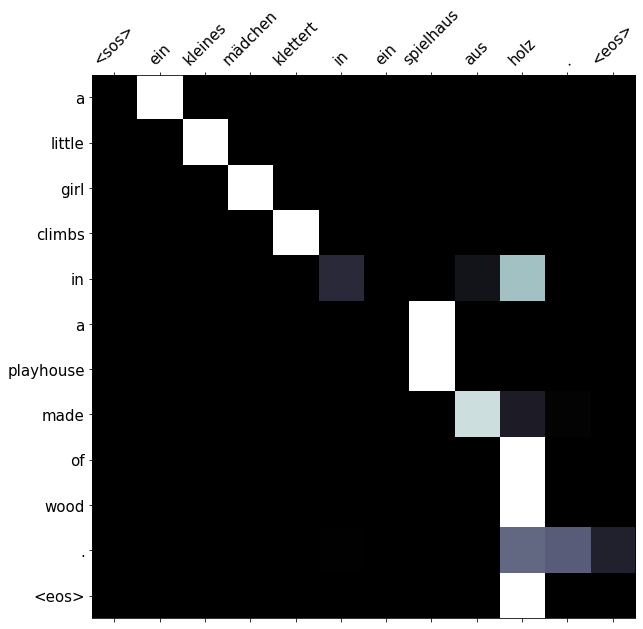

In [ ]:
display_attention(src, translation, attention)

### Observations

1.   Inspite of having more parameters than the RNN model, this model trains faster due to computations performed in parallel
2.   The performance of CNN model is better than the RNN model.

